# Overview
- LIME explanation for image data classification
- The classification task to classify images based on the ImageNet dataset which has a large number of classes such as spider_monkey, binoculars and mosquito_net etc.
- Demo explaining InceptionV3 as a classifier with LimeImageExplainer
- Coding Challenge: Implement the SHAP explanation for the same prediction

## Background
**Implementation of LIME for Images**

The source code of LIME is accessible over [Github](https://github.com/marcotcr/lime). 




## Acknowledgement
The example is based on the LIME tutorial. 

Source Code can be found at: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [ ]:
# Install lime package using pip package manager in the current jupyter environment
!pip install lime
!pip install keras

     |████████████████████████████████| 276kB 5.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=a50415605f2a88f3ae247b4e2cecfe9a585caa91acbc7231a234cf87506b02aa
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
# Import required packages
import os
import urllib.request
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import requests
from skimage.segmentation import mark_boundaries
from PIL import Image

# Import inception_v3 from keras packages
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

# Import lime package
from lime.lime_image import LimeImageExplainer


np.random.seed(0)  # makes the results reproducible

In [ ]:
IMAGE_URL = 'https://raw.githubusercontent.com/marcotcr/lime/master/doc/notebooks/data/cat_mouse.jpg' 

# Download image from the URL
img_data = Image.open(requests.get(IMAGE_URL, stream=True).raw)

In [ ]:
def transform_img_fn(path_list):
    '''Transform image so it can be processed by inception.'''
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

# Explain VGG16 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# input_shape is the shape of our images
# include_top = True includes the fully connected layer of 1000 classes.
vgg_model = VGG16(input_shape = (224, 224, 3), include_top = True, weights = 'imagenet')

vgg_model.summary()

553467904/553467096 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [ ]:
# Pre-process image
width_height_tuple = (224,224)
img = img_data.resize(width_height_tuple, Image.NEAREST)
img = keras.preprocessing.image.img_to_array(img)
img_processed = preprocess_input(np.expand_dims(img, axis=0))

In [ ]:
# Perform prediction
# The classifier is taking an image as an input and classifying it as one of the following classes.

preds = vgg_model.predict(img_processed)
for x in decode_predictions(preds)[0]:
    print(x)


# Load image explainer from LIME package
explainer = LimeImageExplainer()

# First, it generates neighborhood data by randomly perturbing features from the instance then learn locally weighted 
# linear models on the neighborhood data to explain each of the classes in an interpretable way.

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img.astype('double'), 
                                         vgg_model.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

explanation.top_labels

40960/35363 [==================================] - 0s 0us/step
('n02105056', 'groenendael', 0.27900174)
('n02410509', 'bison', 0.26605833)
('n02133161', 'American_black_bear', 0.18154003)
('n02403003', 'ox', 0.069364235)
('n01877812', 'wallaby', 0.041755956)


[295, 347, 294, 345, 224]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


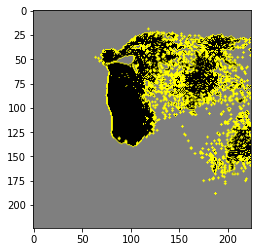

In [ ]:
# The image is divided by 2 and added 0.5 because of how this Inception represents images interception representation
plt.imshow(keras.preprocessing.image.img_to_array(img) / 2 + 0.5)

# The first parameter in "get_image_and_mask()" function is the label which you want the explanation for. 
# Since, we called "explain_instance()" function  with top_labels=5 therfore, it has only 5 labels with 
# highest predicted probabilies. Here, 295 is an identifier of the 'American_black_bear' class/label.

#for label in explanation.top_labels:
img, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=True)

# mask object include a heatmap for the explanations and the code below is just displaying it.
plt.imshow(mark_boundaries(img / 2 + 0.5, mask))

# Explain InceptionV3

In [ ]:
# Load a pretrained inceptionv3 classifier
inet_model = inc_net.InceptionV3()
inet_model.summary()

96116736/96112376 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
# Pre-process image
width_height_tuple = (299,299)
img = img_data.resize(width_height_tuple, Image.NEAREST)
img = keras.preprocessing.image.img_to_array(img)
img_processed = inc_net.preprocess_input(np.expand_dims(img, axis=0))

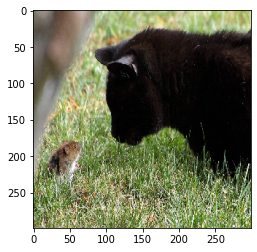

In [ ]:
# The image is divided by 2 and added 0.5 because of how this Inception represents images interception representation
plt.imshow(keras.preprocessing.image.img_to_array(img) / 2 + 0.5)

In [ ]:
# Perform prediction
# The classifier is taking an image as an input and classifying it as one of the following classes.
preds = inet_model.predict(img_processed)
for x in decode_predictions(preds)[0]:
    print(x)

('n02133161', 'American_black_bear', 0.63715863)
('n02105056', 'groenendael', 0.031818125)
('n02104365', 'schipperke', 0.029944414)
('n01883070', 'wombat', 0.028509548)
('n01877812', 'wallaby', 0.025093656)


In [ ]:
# Load image explainer from LIME package
explainer = LimeImageExplainer()

# First, it generates neighborhood data by randomly perturbing features from the instance then learn locally weighted 
# linear models on the neighborhood data to explain each of the classes in an interpretable way.

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img.astype('double'), 
                                         inet_model.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

In [ ]:
# Get the top labels from the explanations. 
# The numeric values represents a class label associated with it. 
# For example 295 is an identifier of the 'American_black_bear' class.
explanation.top_labels

[295, 224, 223, 106, 104]

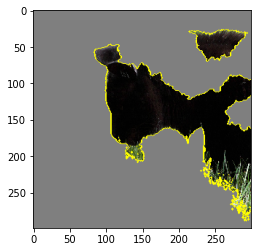

In [ ]:
# The first parameter in "get_image_and_mask()" function is the label which you want the explanation for. 
# Since, we called "explain_instance()" function  with top_labels=5 therfore, it has only 5 labels with 
# highest predicted probabilies. Here, 295 is an identifier of the 'American_black_bear' class/label.
img, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=True)

# mask object include a heatmap for the explanations and the code below is just displaying it.
plt.imshow(mark_boundaries(img / 2 + 0.5, mask))

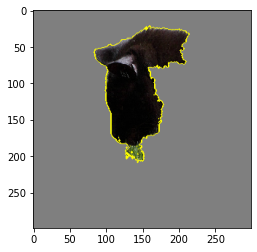

In [ ]:
# The first parameter in "get_image_and_mask()" function is the label which you want the explanation for. Since, we called "explain_instance()" function 
# with top_labels=5 therfore, it has only 5 labels with highest predicted probabilies. Here, 295 is an identifier of the 'American_black_bear' class/label.
img, mask = explanation.get_image_and_mask(224, positive_only=True, num_features=5, hide_rest=True)

# mask object include a heatmap for the explanations and the code below is just displaying it.
plt.imshow(mark_boundaries(img / 2 + 0.5, mask))

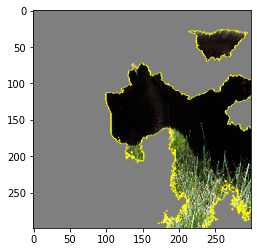

In [ ]:
# The first parameter in "get_image_and_mask()" function is the label which you want the explanation for. Since, we called "explain_instance()" function 
# with top_labels=5 therfore, it has only 5 labels with highest predicted probabilies. Here,106 is an identifier of the 'wombat' class/label.
img, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)

# mask object include a heatmap for the explanations and the code below is just displaying it.
plt.imshow(mark_boundaries(img / 2 + 0.5, mask))

**Understanding the Explanations**


LIME is weighting the perturbed images by their similarity to the instance we want to explain. It is displaying top 5 superpixels that are most positive towards the class with the rest of the image hidden. Superpixels based image segmentation are frequent choices for explaining images. Each patch of superpixels is representing a class and its probablity by turning some of the interpretable components “off”. 

For example the first patch of superpixels is representing a class label **295** which is "American_black_bear" with the predicting probability of 0.6371595. Similary, second patch of superpixels is representing a class label **224** which is "groenendael" with the predicting probability of 0.031818032. As we can observe from the above images after plotting the first patch of superpixels that, the explainer in more focusing on the face of American black bear. These pacthes of superpixels are the explanations generated with LIME. 

At the end, LIME presents the superpixels with highest positive weights as an explanation, graying out everything else. The first patch of the superpixels has the highest weight (0.637) that reveals that the classifier primarily focuses on the American black bear’s face as an explanation for the predicted class. 

# Explore LIME Package Documentation

In [ ]:
help( LimeImageExplainer)

Help on class LimeImageExplainer in module lime.lime_image:

class LimeImageExplainer(builtins.object)
 |  Explains predictions on Image (i.e. matrix) data.
 |  For numerical features, perturb them by sampling from a Normal(0,1) and
 |  doing the inverse operation of mean-centering and scaling, according to the
 |  means and stds in the training data. For categorical features, perturb by
 |  sampling according to the training distribution, and making a binary
 |  feature that is 1 when the value is the same as the instance being
 |  explained.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, kernel_width=0.25, kernel=None, verbose=False, feature_selection='auto', random_state=None)
 |      Init function.
 |      
 |      Args:
 |          kernel_width: kernel width for the exponential kernel.
 |          If None, defaults to sqrt(number of columns) * 0.75.
 |          kernel: similarity kernel that takes euclidean distances and kernel
 |              width as input and outputs we

# Coding Challenge:
- Implement the SHAP explanation for the same prediction.
- For Random Forest, obtain the global feature importance.
- Compare the feature explanations given by LIME, SHAP and Random Forest
- Experiment with changing the number of iterations for LIME explanation